In [37]:
import numpy as np
import pandas as pd
import os
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
pip install --editable ..

## Data formatting for classification

In [3]:
# Unpickle data 
with open('/Users/greenapple/project3/data/processed/house_bal.pkl', 'rb') as f:
    house_bal = pickle.load(f)

In [4]:
house_bal.head()

,video_id_list,y,y_name,0,1,2,3,4,5,6,...,630,631,632,633,634,635,636,637,638,639
5,b'--ZhevVpy1s',375,toothbrush,117,35,163,90,198,103,63,...,0,1,202,9,116,0,247,72,44,166
20,b'-2hQKCE-oTI',53,footsteps,30,162,44,7,216,116,206,...,213,109,50,88,19,46,54,154,42,211
28,b'-3pPrlCm6gg',198,clarinet,179,190,122,19,0,114,255,...,58,15,207,0,108,43,97,57,42,0
63,b'-70wVF5u-gg',366,chopping_food,0,114,186,34,87,250,58,...,0,122,144,63,110,255,139,138,59,154
82,b'-ASYwidRD7M',43,snoring,53,100,144,84,223,68,95,...,56,78,153,65,208,207,200,255,255,66


In [5]:
house_bal.shape

(45717, 643)

In [6]:
len(house_bal.y_name.value_counts())

30

In [7]:
house_bal.y_name.value_counts()

speech            4042
music             3781
laughter          3772
snoring           3370
vacuum_cleaner    3054
typing            2644
dishes_pots       2560
frying_food       2102
blender           1884
toilet_flush      1882
door              1868
whoop             1736
footsteps         1492
baby_cry          1414
screeming         1116
whispering         972
clarinet           960
crying             918
microwave          894
television         866
hair_dryer         772
video_games        592
shaving            552
bathtab            472
water_tap          458
chopping_food      410
meow               388
dog                358
purr               304
toothbrush          84
Name: y_name, dtype: int64

In [8]:
ten_class_list = [
    'speech',
    'music',
    'clarinet',
    'water_tap',
    'footsteps',
    'microwave',
    'door',
    'blender',
    'vacuum_cleaner',
    'meow'
]

In [9]:
house_10_classes = house_bal.loc[house_bal.y_name.isin(ten_class_list)]

In [10]:
house_10_classes.shape

(18821, 643)

In [11]:
house_10_classes.head()

,video_id_list,y,y_name,0,1,2,3,4,5,6,...,630,631,632,633,634,635,636,637,638,639
20,b'-2hQKCE-oTI',53,footsteps,30,162,44,7,216,116,206,...,213,109,50,88,19,46,54,154,42,211
28,b'-3pPrlCm6gg',198,clarinet,179,190,122,19,0,114,255,...,58,15,207,0,108,43,97,57,42,0
112,b'-Dtir74TiUM',137,music,171,99,67,170,122,148,53,...,2,214,45,0,0,54,160,255,109,66
138,b'-G_hnfp4a0M',53,footsteps,141,93,96,107,139,0,220,...,250,104,46,0,98,12,234,61,81,133
150,b'-IWlQN6cfe4',53,footsteps,78,146,188,30,200,44,120,...,130,96,33,255,83,228,123,120,58,236


In [75]:
# Assign features X and target y
X = house_10_classes[house_10_classes.columns[3:643]]
y = house_10_classes.y_name

In [76]:
X.shape

(18821, 640)

## Model functions

In [ ]:
import numpy as np
import pandas as pd
import pickle
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import SVC

from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from imblearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import sklearn
from datetime import datetime

# Function for finding the best parameters
def train_transform_fit_time(model,
                   param_distributions,
                   sampler,          
                   transformer,
                   X_train,
                   X_test,
                   y_train,
                   y_test,
                   CV):

    '''Function searches for the best model paramenters through a cross-validation on the train set
    and returns results of test set fit.

    Args:
        model - supervised learning classifier
        param_grid (dict) - set of model specific parameters
        transformer - data transformer
        X_train (DataFrame) - training data set
        y_train (DataFrame) - training target set
        X_test (DataFrame) - test data set
        y_test (DataFrame) - test traget set
        CV (int) - number of cross-validation folds

    Returns:
        dictionary with the following keys:
            train_score
            test_score
            time (sec) - how long this function runs for
            time_best_fit (sec)
            params
            estimator
            test_proba
            y_hat
            all_scores
        model
    '''
    # Time the function: record start time
    start_time = datetime.now()

    pipe = Pipeline([('sampler', sampler), ('transformer', transformer), ('model', model)])

    # Parameter grid
    grid = RandomizedSearchCV(pipe, param_distributions, cv=CV, scoring='f1_micro', refit=True, n_jobs=-1)
    grid.fit(X_train, y_train)

    # Time the function: record end time
    end_time = datetime.now()
    time = (end_time - start_time).total_seconds()

    # Parameters and scores
    params_scores_pred = {
        'best_train_score':grid.best_score_,
        'best_test_score': grid.score(X_test, y_test),
        'time_sec': time,
        'time_best_fit_sec': time_best_fit(grid, X_train, y_train),
        'best_params':grid.best_params_,
        'best_estimator':grid.best_estimator_,
        'best_test_proba': grid.predict_proba(X_test),
        'best_y_hat': grid.predict(X_test),
        'all_scores': grid.cv_results_

    }

    return params_scores_pred, grid


# Function for estimating the run time for the best fit
def time_best_fit(grid, X_train, y_train):

    '''Function returns the time of fit for the best parameters found by GridSearchCV.

    Args:
       best model from train_fit_time() - grid.

    Returns:
       time of fit in seconds.
    '''

    # Time the function: record start time
    start_time = datetime.now()

    pipe = grid.best_estimator_

    # Time the function: record start time
    start_time = datetime.now()

    # Fit
    pipe.fit(X_train, y_train)

    # Time the function: record end time
    end_time = datetime.now()
    fit_time = (end_time - start_time).total_seconds()

    if int(fit_time) < 5.0:
        time = 0
        for i in range(4):
            start_time_ = datetime.now()
            pipe.fit(X_train, y_train)
            start_time_ = datetime.now()
            time = (end_time - start_time).total_seconds()
            time += time
        fit_time = (time + fit_time)/5

    return fit_time


## PCA to reduce the number of features

In [61]:
# Function to make train/test sets for different number of features
def feature_pca(X, n_features_to_keep):
    # Reduce the number of features
    pca = PCA(n_components=n_features_to_keep)
    X_pca_array = pca.fit_transform(X)
    X_pca = pd.DataFrame(X_pca_array)
    X_pca.reset_index(drop=True, inplace=True)
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=3) 
    
    return X_train, X_test, y_train, y_test

In [83]:
# MAke PCA features
pca = PCA(n_components=640)
X_pca_array = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca_array)
X_pca.reset_index(drop=True, inplace=True)
X_pca

,0,1,2,3,4,5,6,7,8,9,...,630,631,632,633,634,635,636,637,638,639
0,-216.390736,151.485092,147.345767,104.474544,-342.600308,-391.360295,312.139218,-130.488243,119.761742,-124.492763,...,-10.374244,0.696315,6.183557,-18.470741,16.830933,4.710431,7.356244,3.600197,13.083149,8.662261
1,-282.459831,-727.340211,-372.113901,-244.315453,585.862596,-1.749334,306.471520,-29.291852,4.067889,143.517473,...,-2.956251,-28.249026,13.016194,13.677100,26.312044,2.967112,0.803673,8.173672,-22.091548,17.835097
2,-350.770959,-26.848373,-145.423025,-73.494471,-124.445394,90.895195,94.124605,-123.658668,127.845924,-106.528014,...,-7.289957,10.834340,7.761291,-22.941221,9.673474,5.618488,5.172538,-3.619531,20.935131,1.791905
3,-349.792098,46.444614,17.613245,-147.349085,-80.769972,105.384332,7.734681,22.069538,15.855357,240.826117,...,-12.461335,-0.231591,-15.641041,-28.650872,-7.165625,4.854420,16.927042,13.724127,13.658602,-9.519648
4,-59.982535,-69.612600,77.240508,159.980557,-188.163116,-383.267173,-45.910100,-43.300374,-234.053120,59.314028,...,-11.649428,11.193187,39.378961,-20.013109,23.820985,-26.138539,-3.225318,1.903101,-1.054513,0.496201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18816,-184.888781,-494.414589,-181.743016,-109.231470,232.313158,136.166615,86.374646,24.618947,23.699911,-138.821079,...,-31.574214,-39.267436,-9.649099,12.701127,-9.580996,22.236308,-33.334869,1.861903,6.548398,-17.600323
18817,792.548230,191.903215,-62.758092,-617.006182,-29.457242,206.150293,280.795195,-485.428548,-12.758854,-146.128822,...,-0.079245,1.475288,2.173309,-3.565749,-6.451635,-9.079809,-8.821101,6.982047,-6.271389,14.004828
18818,-517.448188,-965.371829,-552.548039,-286.082296,663.275875,-256.024653,211.058585,46.495779,161.879459,-288.185975,...,-3.746359,9.326492,-16.331444,20.339983,37.945731,-4.857753,-25.930918,6.985149,-17.684437,-27.133329
18819,-342.210246,154.148629,-206.866981,-74.439436,-150.670894,-24.381451,-77.557270,-161.241740,98.432099,301.179625,...,1.693250,-0.259967,2.345910,1.146922,11.202428,12.075994,-2.555898,4.399251,2.079172,2.010926


In [98]:
# Function returns F1 score for a given model and X/y set
def model_score(model):
    model.fit(X_train, y_train)
    
    y_hat = model.predict(X_test)
    f1_test = f1_score(y_test, y_hat, average='micro')
    
    
    y_hat_train = model.predict(X_train)
    f1_train = f1_score(y_train, y_hat_train, average='micro')
    return f1_test, f1_train

In [107]:
# Reassign features X and target y
X = house_10_classes[house_10_classes.columns[3:643]]
y = house_10_classes.y_name

In [108]:
# Compare F1 scores for different number of features no PCA
model = RandomForestClassifier(n_estimators=100)
f1_test_ = {}
f1_train_ = {}

for i in list(range(20, 641, 20)):
    X_ = X[X.columns[:i]]
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=3) 
    
    # oversample
    transformer = RandomOverSampler(random_state=3, sampling_strategy='minority')
    X_train, y_train = transformer.fit_resample(X_train, y_train)
    
    # return test f1 score
    f1_test, f1_train = model_score(model)
    
    f1_test_[i] = f1_test
    f1_train_[i] = f1_train

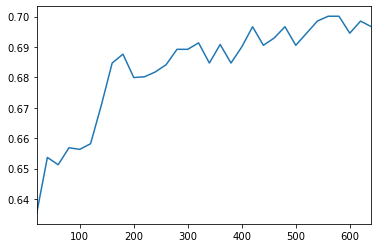

In [109]:
pd.Series(f1_test_).plot()

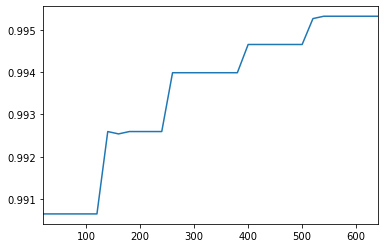

In [110]:
pd.Series(f1_train_).plot()

In [100]:
# Compare F1 scores for different number of features after PCA
model = RandomForestClassifier(n_estimators=100)
f1_test_psa_ = {}
f1_train_psa_ = {}

for i in list(range(20, 641, 20)):
    X = X_pca[X_pca.columns[:i]]
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3) 
    
    # oversample
    transformer = RandomOverSampler(random_state=3, sampling_strategy='minority')
    X_train, y_train = transformer.fit_resample(X_train, y_train)
    
    # return test f1 score
    f1_test, f1_train = model_score(model)
    
    f1_test_psa_[i] = f1_test
    f1_train_psa_[i] = f1_train

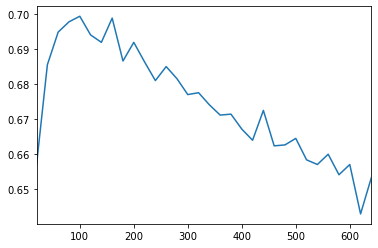

In [102]:
pd.Series(f1_test_psa_).plot()


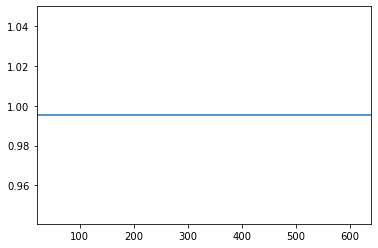

In [103]:
pd.Series(f1_train_psa_).plot()

In [86]:
# Reassign features X and target y
X = house_10_classes[house_10_classes.columns[3:643]]
y = house_10_classes.y_name

In [92]:
X.shape

(18821, 640)

In [95]:
# Compare F1 scores for different number of features no PCA
model = RandomForestClassifier(n_estimators=100)
f1_test_psa_ = {}
f1_train_psa_ = {}

for i in list(range(20, 641, 20)):
    X_ = X[X.columns[:i]]
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3) 
    
    # oversample
    transformer = RandomOverSampler(random_state=3, sampling_strategy='minority')
    X_train, y_train = transformer.fit_resample(X_train, y_train)
    
    # return test f1 score
    f1_test, f1_train = model_score(model)
    
    f1_test_psa_[i] = f1_test
    f1_train_psa_[i] = f1_train

In [96]:
results_no_pca

{20: 0.6353253652058433,
 40: 0.651527224435591,
 60: 0.6557768924302789,
 80: 0.652324037184595,
 100: 0.6552456839309428,
 120: 0.6560424966799469,
 140: 0.6714475431606906,
 160: 0.6828685258964143,
 180: 0.6855245683930943,
 200: 0.6815405046480744,
 220: 0.6799468791500664,
 240: 0.6767596281540504,
 260: 0.6807436918990704,
 280: 0.6895086321381142,
 300: 0.6884462151394423,
 320: 0.6911022576361222,
 340: 0.6972111553784861,
 360: 0.6889774236387782,
 380: 0.6892430278884463,
 400: 0.6911022576361222,
 420: 0.6876494023904383,
 440: 0.6911022576361222,
 460: 0.6945551128818062,
 480: 0.6945551128818062,
 500: 0.6913678618857901,
 520: 0.6942895086321381,
 540: 0.69535192563081,
 560: 0.699867197875166,
 580: 0.69667994687915,
 600: 0.6918990703851262,
 620: 0.7033200531208499,
 640: 0.6918990703851262}

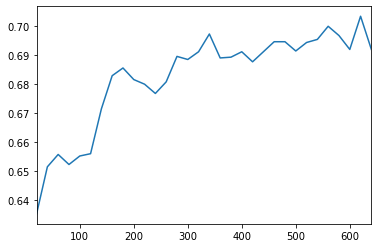

In [97]:
pd.Series(results_no_pca).plot()

In [66]:
results_fldr = '/Users/greenapple/project3/results'

In [69]:
pickling_in = open(os.path.join(results_fldr, 'pca_RF_results.pkl'), 'wb')
pickle.dump(results, pickling_in)

In [71]:
pickling_out = open(os.path.join(results_fldr, 'pca_RF_results.pkl'), 'rb')
pca_RF_results = pickle.load(pickling_out)

In [72]:
pca_RF_results

{20: 0.6552456839309428,
 40: 0.6881806108897742,
 60: 0.7027888446215139,
 80: 0.699867197875166,
 100: 0.702523240371846,
 120: 0.6950863213811421,
 140: 0.6921646746347941,
 160: 0.6969455511288181,
 180: 0.6937583001328022,
 200: 0.6863213811420983,
 220: 0.6818061088977424,
 240: 0.6815405046480744,
 260: 0.6828685258964143,
 280: 0.6831341301460824,
 300: 0.6714475431606906,
 320: 0.6812749003984063,
 340: 0.6693227091633466,
 360: 0.6687915006640106,
 380: 0.6666666666666666,
 400: 0.6711819389110226,
 420: 0.6671978751660027,
 440: 0.6648074369189907,
 460: 0.6674634794156706,
 480: 0.653652058432935,
 500: 0.6621513944223107,
 520: 0.6687915006640106,
 540: 0.653120849933599,
 560: 0.650996015936255,
 580: 0.649667994687915,
 600: 0.6456839309428951,
 620: 0.6621513944223107,
 640: 0.648871181938911}

In [47]:
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3) 

In [57]:
model = RandomForestClassifier(n_estimators=50)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
f1_test = f1_score(y_test, y_hat, average='micro')
f1_test

0.6778220451527225

In [56]:
transformer = RandomOverSampler(random_state=3, sampling_strategy='minority')
X_train, y_train = transformer.fit_resample(X_train, y_train)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((17964, 640), (17964,), (3765, 640), (3765,))

In [52]:
f1_test = f1_score(y_test, y_hat, average='micro')
f1_test

0.6889774236387782

## Build and evaluate models

### Logistic regression

In [ ]:
model_fldr = '/Users/greenapple/project3/models/'

In [ ]:
# Train and fit logistic regression with  RandomizedSearchCV: 3rd set of parameteres
# from src.models import model_sel_rand_search

# Function arguments:
model = LogisticRegression(random_state=3, multi_class='multinomial')
transformer = StandardScaler()
sampler = RandomOverSampler(random_state=3, sampling_strategy='minority')
CV = 5

# Function arguments: classifier params
penalty = ['l2']
C = np.logspace(0, 4, 10)
solver = ['sag', 'lbfgs', 'newton-cg']

param_distributions = dict(
        model__C = C, 
        model__penalty = penalty,
        model__solver=solver
)

# Call parameter selection function
logreg3_5_cls_scores_params, logreg3_5_cls_model = train_transform_fit_time(model,
                                                                               param_distributions,
                                                                               sampler,
                                                                               transformer,
                                                                               X_train,
                                                                               X_test,
                                                                               y_train,
                                                                               y_test,
                                                                               CV)
# Pickle results
with open(os.path.join(model_fldr,'logreg3_5_cls_scores_params_rand_scl.pkl'), 'wb') as f:
    pickle.dump(logreg3_5_cls_scores_params, f)
    
# Pickle model
with open(os.path.join(model_fldr, 'logreg3_5_cls_model_rand_scl.pkl'), 'wb') as f:
    pickle.dump(logreg3_5_cls_model, f)  

In [ ]:
# Pickle results
with open(os.path.join(model_fldr,'logreg3_5_cls_scores_params_rand_scl.pkl'), 'wb') as f:
    pickle.dump(logreg3_5_cls_scores_params, f)
    
# Pickle model
with open(os.path.join(model_fldr, 'logreg3_5_cls_model_rand_scl.pkl'), 'wb') as f:
    pickle.dump(logreg3_5_cls_model, f) 

In [ ]:
logreg3_5_cls_scores_params

In [ ]:
# Train and fit logistic regression with  RandomizedSearchCV: 3rd set of parameteres
from src.models import model_sel_rand_search

# Function arguments:
model = LogisticRegression(random_state=3, multi_class='multinomial')
transformer = StandardScaler()
sampler = RandomOverSampler(random_state=3, sampling_strategy='minority')
CV = 5

# Function arguments: classifier params
penalty = ['l2']
C = np.logspace(0, 4, 10)
solver = ['sag', 'lbfgs', 'newton-cg']

param_distributions = dict(
        model__C = C, 
        model__penalty = penalty,
        model__solver=solver
)

# Call parameter selection function
logreg3_5_cls_scores_params, logreg3_5_cls_model = model_sel_rand_search.train_fit_time(model,
                                                                               param_distributions,
                                                                               transformer,
                                                                               X_train,
                                                                               X_test,
                                                                               y_train,
                                                                               y_test,
                                                                               CV)
# Pickle results
with open(os.path.join(model_fldr,'logreg3_5_cls_scores_params_rand.pkl'), 'wb') as f:
    pickle.dump(logreg3_5_cls_scores_params, f)
    
# Pickle model
with open(os.path.join(model_fldr, 'logreg3_5_cls_model_rand.pkl'), 'wb') as f:
    pickle.dump(logreg3_5_cls_model, f)  

### K-Nearest Neighbors

In [ ]:
# Train and fit KNN
from src.models import model_sel_grid

# Function arguments:
model = KNeighborsClassifier()
transformer = RandomOverSampler(random_state=3, sampling_strategy='minority')
CV = 5

# Function arguments: classifier params
k_range = range(1, 31)

param_grid = dict(model__n_neighbors=k_range)

# Call parameter selection function
KNN_2_cls_scores_params, KNN_2_cls_models = model_sel_grid.train_fit_time(model,
                                                                               param_grid,
                                                                               transformer,
                                                                               X_train,
                                                                               X_test,
                                                                               y_train,
                                                                               y_test,
                                                                               CV)

# Pickle results
with open('/Users/greenapple/project3/models/KNN_2_cls_scores_params.pkl', 'wb') as f:
    pickle.dump(KNN_2_cls_scores_params, f)
    
# Pickle model
with open('/Users/greenapple/project3/models/KNN_2_cls_models.pkl', 'wb') as f:
    pickle.dump(KNN_2_cls_models, f)

### Naive Bayes MultiNomial

In [ ]:
# Train and fit naive Bayes MultiNomial
from src.models import model_sel_grid

# Function arguments:
model = MultinomialNB()
transformer = RandomOverSampler(random_state=3, sampling_strategy='minority')
CV = 5

# Function arguments: classifier params
alphas = [1, 10, 100]
# Selects the min alpha. Keep alpha = 1 to make sure the model can take data it has not seen before 
# from the test set.

param_grid = dict(model__alpha=alphas)

# Call parameter selection function
NBmultinomial_2_cls_scores_params, NBmultinomial_2_cls_models = model_sel_grid.train_fit_time(model,
                                                                               param_grid,
                                                                               transformer,
                                                                               X_train,
                                                                               X_test,
                                                                               y_train,
                                                                               y_test,
                                                                               CV)

# Pickle results
with open('/Users/greenapple/project3/models/NBmultinomial_2_cls_scores_params.pkl', 'wb') as f:
    pickle.dump(NBmultinomial_2_cls_scores_params, f)
    
# Pickle model
with open('/Users/greenapple/project3/models/NBmultinomial_2_cls_models.pkl', 'wb') as f:
    pickle.dump(NBmultinomial_2_cls_models, f)

### Support Vector Machines

In [ ]:
# Train and fit SVC
from src.models import model_sel_grid

# Function arguments:
model = svm.SVC(probability=True)
transformer = RandomOverSampler(random_state=3, sampling_strategy='minority')
CV = 5

# Function arguments: classifier params
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
C = [0.001, 0.01, 0.1, 1, 10]
gamma = [0.001, 0.01, 0.1, 1]
degree = [2, 3]

param_grid = dict(model__C=C,
                 model__kernel=kernel,
                 model__gamma=gamma,
                 model__degree=degree
                 )

# Call parameter selection function
SVC_2_cls_scores_params, SVC_2_cls_models = model_sel_grid.train_fit_time(model,
                                                                               param_grid,
                                                                               transformer,
                                                                               X_train,
                                                                               X_test,
                                                                               y_train,
                                                                               y_test,
                                                                               CV)

# Pickle results
with open('/Users/greenapple/project3/models/SVC_2_cls_scores_params.pkl', 'wb') as f:
    pickle.dump(SVC_2_cls_scores_params, f)
    
# Pickle model
with open('/Users/greenapple/project3/models/SVC_2_cls_models.pkl', 'wb') as f:
    pickle.dump(SVC_2_cls_models, f)

In [ ]:
SVC_2_cls_scores_params

In [ ]:
# Unpickle data 
with open('/Users/greenapple/project3/models/SVC_2_classes.pkl', 'rb') as f:
    SVC_2_classes = pickle.load(f)
SVC_2_classes

### Random Forest

In [ ]:
# Train and fit Random Forest over fewer parameters
from src.models import model_sel_grid

# Function arguments:
model = RandomForestClassifier(random_state=3)
transformer = RandomOverSampler(random_state=3, sampling_strategy='minority')
CV = 5

# Function arguments: classifier params
n_estimators = [50, 100, 300]
criterion = ['gini', 'entropy']
max_depth = [5, 50, None]
min_samples_split = [2, 10]
max_features = [25]
bootstrap = [True]

                
param_grid = dict(model__n_estimators=n_estimators,
                  model__criterion=criterion,
                  model__max_depth=max_depth,
                  model__min_samples_split=min_samples_split,
                  model__max_features=max_features,
                  model__bootstrap=bootstrap
                 )

# Call parameter selection function
RF_2_cls_scores_params, RF_2_cls_models = model_sel_grid.train_fit_time(model,
                                                                        param_grid,
                                                                        transformer,
                                                                        X_train,
                                                                        X_test,
                                                                        y_train,
                                                                        y_test,
                                                                        CV)

# Pickle results
with open('/Users/greenapple/project3/models/RF_2_cls_scores_fewer_params.pkl', 'wb') as f:
    pickle.dump(RF_2_cls_scores_fewer_params, f)
    
# Pickle model
with open('/Users/greenapple/project3/models/RF_2_cls_models_fewer.pkl', 'wb') as f:
    pickle.dump(RF_2_cls_models_fewer, f)

In [ ]:
# Train and fit Random Forest
from src.models import model_sel_grid

# Function arguments:
model = RandomForestClassifier(random_state=3)
transformer = RandomOverSampler(random_state=3, sampling_strategy='minority')
CV = 5

# Function arguments: classifier params
n_estimators = [50, 100, 200, 300]
criterion = ['gini', 'entropy']
max_depth = [5, 10, 50, 100, None]
min_samples_split = [2, 5, 10]
max_features = [5, 10, 25]
bootstrap = [True, False]

                
param_grid = dict(model__n_estimators=n_estimators,
                  model__criterion=criterion,
                  model__max_depth=max_depth,
                  model__min_samples_split=min_samples_split,
                  model__max_features=max_features,
                  model__bootstrap=bootstrap
                 )

# Call parameter selection function
RF_2_cls_scores_params, RF_2_cls_models = model_sel_grid.train_fit_time(model,
                                                                        param_grid,
                                                                        transformer,
                                                                        X_train,
                                                                        X_test,
                                                                        y_train,
                                                                        y_test,
                                                                        CV)

# Pickle results
with open('/Users/greenapple/project3/models/RF_2_cls_scores_params.pkl', 'wb') as f:
    pickle.dump(RF_2_cls_scores_params, f)
    
# Pickle model
with open('/Users/greenapple/project3/models/RF_2_cls_models.pkl', 'wb') as f:
    pickle.dump(RF_2_cls_models, f)

In [ ]:
pickle_out = open('/Users/greenapple/project3/models/RF_2_cls_scores_params.pkl', 'rb')
RF_2_cls_scores_params = pickle.load(pickle_out)
RF_2_cls_scores_params

In [ ]:
# Train and fit Random Forest: addinig additional parameteres to the search
from src.models import model_sel_grid

# Function arguments:
model = RandomForestClassifier(random_state=3)
transformer = RandomOverSampler(random_state=3, sampling_strategy='minority')
CV = 5

# Function arguments: classifier params
n_estimators = [10, 20, 50, 100, 300]
criterion = ['gini', 'entropy']
max_depth = [5, 10, 100, None]
min_samples_split = [5, 10, 20, 50]
max_features = [10, 25, 50, 100]
bootstrap = [True, False]

                
param_grid = dict(model__n_estimators=n_estimators,
                  model__criterion=criterion,
                  model__max_depth=max_depth,
                  model__min_samples_split=min_samples_split,
                  model__max_features=max_features,
                  model__bootstrap=bootstrap
                 )

# Call parameter selection function
RF_2_cls_scores_more_params, RF_2_cls_model_more = model_sel_grid.train_fit_time(model,
                                                                        param_grid,
                                                                        transformer,
                                                                        X_train,
                                                                        X_test,
                                                                        y_train,
                                                                        y_test,
                                                                        CV)

# Pickle results
with open('/Users/greenapple/project3/models/RF_2_cls_scores_more_params.pkl', 'wb') as f:
    pickle.dump(RF_2_cls_scores_more_params, f)
    
# Pickle model
with open('/Users/greenapple/project3/models/RF_2_cls_model_more.pkl', 'wb') as f:
    pickle.dump(RF_2_cls_model_more, f)

In [ ]:
pickle_out = open('/Users/greenapple/project3/models/RF_2_cls_scores_more_params.pkl', 'rb')
RF_2_cls_scores_more_params = pickle.load(pickle_out)
RF_2_cls_scores_more_params

### Gradient Boosting Classifier

In [ ]:
# Train and fit Gradient Boosting
from src.models import model_sel_grid

# Function arguments:
model = GradientBoostingClassifier(random_state=3)
transformer = RandomOverSampler(random_state=3, sampling_strategy='minority')
CV = 5

# Function arguments: classifier params
n_estimators = [50, 100, 200, 300]
max_depth = [5, 10, 50, 100, None]
min_samples_split = [2, 5, 10]
max_features = [5, 10, 25]

                
param_grid = dict(model__n_estimators=n_estimators,
                  model__max_depth=max_depth,
                  model__min_samples_split=min_samples_split,
                  model__max_features=max_features,
                 )

# Call parameter selection function
GBM_2_cls_scores_params, GBM_2_cls_models = model_sel_grid.train_fit_time(model,
                                                                        param_grid,
                                                                        transformer,
                                                                        X_train,
                                                                        X_test,
                                                                        y_train,
                                                                        y_test,
                                                                        CV)

# Pickle results
with open('/Users/greenapple/project3/models/GBM_2_cls_scores_params.pkl', 'wb') as f:
    pickle.dump(GBM_2_cls_scores_params, f)
    
# Pickle model
with open('/Users/greenapple/project3/models/GBM_2_cls_models.pkl', 'wb') as f:
    pickle.dump(GBM_2_cls_models, f)

In [ ]:
GBM_2_cls_scores_params

In [ ]:
# Train and fit Gradient Boosting: expanding parameter search
from src.models import model_sel_grid

# Function arguments:
model = GradientBoostingClassifier(random_state=3)
transformer = RandomOverSampler(random_state=3, sampling_strategy='minority')
CV = 5

# Function arguments: classifier params
n_estimators = [50, 100, 300, 500, 900]
max_depth = [1, 3, 5, 10, 50, None]
min_samples_split = [5, 10, 20, 50]
max_features = [2, 3, 5, 25]

                
param_grid = dict(model__n_estimators=n_estimators,
                  model__max_depth=max_depth,
                  model__min_samples_split=min_samples_split,
                  model__max_features=max_features,
                 )

# Call parameter selection function
GBM_2_cls_scores_params, GBM_2_cls_models = model_sel_grid.train_fit_time(model,
                                                                        param_grid,
                                                                        transformer,
                                                                        X_train,
                                                                        X_test,
                                                                        y_train,
                                                                        y_test,
                                                                        CV)

# Pickle results
with open('/Users/greenapple/project3/models/GBM_2_cls_scores_params.pkl', 'wb') as f:
    pickle.dump(GBM_2_cls_scores_params, f)
    
# Pickle model
with open('/Users/greenapple/project3/models/GBM_2_cls_models.pkl', 'wb') as f:
    pickle.dump(GBM_2_cls_models, f)

In [ ]:
# Train and fit Gradient Boosting over fewer parameters
from src.models import model_sel_grid

# Function arguments:
model = GradientBoostingClassifier(random_state=3)
transformer = RandomOverSampler(random_state=3, sampling_strategy='minority')
CV = 5

# Function arguments: classifier params
n_estimators = [50, 100, 300]
max_depth = [5, 50, None]
min_samples_split = [2, 10]
max_features = [25]

                
param_grid = dict(model__n_estimators=n_estimators,
                  model__max_depth=max_depth,
                  model__min_samples_split=min_samples_split,
                  model__max_features=max_features,
                 )

# Call parameter selection function
GBM_2_cls_scores_fewer_params, GBM_2_cls_model_fewer = model_sel_grid.train_fit_time(model,
                                                                        param_grid,
                                                                        transformer,
                                                                        X_train,
                                                                        X_test,
                                                                        y_train,
                                                                        y_test,
                                                                        CV)

# Pickle results
with open('/Users/greenapple/project3/models/GBM_2_cls_scores_fewer_params.pkl', 'wb') as f:
    pickle.dump(GBM_2_cls_scores_fewer_params, f)
    
# Pickle model
with open('/Users/greenapple/project3/models/GBM_2_cls_model_fewer.pkl', 'wb') as f:
    pickle.dump(GBM_2_cls_model_fewer, f)

In [ ]:
GBM_2_cls_scores_fewer_params

### Dummy classifier

In [ ]:
# Train and fit Dummy classifier

# Function arguments:
model = DummyClassifier(random_state=3, strategy='stratified')
transformer = RandomOverSampler(random_state=3, sampling_strategy='minority')
CV = 5

# Function arguments: classifier params

param_grid = dict()

# Call parameter selection function
Dummy_2_cls_scores_params, Dummy_2_cls_model = model_sel_grid.train_fit_time(model,
                                                                        param_grid,
                                                                        transformer,
                                                                        X_train,
                                                                        X_test,
                                                                        y_train,
                                                                        y_test,
                                                                        CV)

# Pickle results
with open('/Users/greenapple/project3/models/Dummy_2_cls_scores_params.pkl', 'wb') as f:
    pickle.dump(Dummy_2_cls_scores_params, f)
    
# Pickle model
with open('/Users/greenapple/project3/models/Dummy_2_cls_model.pkl', 'wb') as f:
    pickle.dump(Dummy_2_cls_model, f)

In [ ]:
Dummy_2_cls_scores_params

In [ ]:
# Dummy classifier
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
f1_dummy = f1_score(y_test, dummy.predict(X_test), average='micro')
accuracy_dummy = accuracy_score(y_test, dummy.predict(X_test))

In [ ]:
print('Dummy classifier F1 score: ', f1_dummy)
print('Dummy classifier accuracy score: ', accuracy_dummy)

### Null accuracy

In [ ]:
y_test.value_counts()

In [ ]:
null_accuracy = y_test.value_counts().head(1) / len(y_test)
print('Null accuracy: ', null_accuracy)

## Visualize scores

### Model summary

In [ ]:
model_score_table = pd.DataFrame(columns=['Models', 'F1_score_train'])
model_score_table

In [ ]:
model_score_table['Models'] = ['Logistis_Regression',
                              'KNN',
                              'Multinomial_NB',
                              'SVC_poly',
                              'Random_Forest',
                               'GBM',
                               'Dummy'
                              ]

In [ ]:
model_score_table['F1_score_train'] = trainin

In [ ]:
model_score_table

In [ ]:
# Pickle results
with open('/Users/greenapple/project3/reports/figures/model_score_table_MVP.pkl', 'wb') as f:
    pickle.dump(model_score_table, f)

### Confusion matrix

In [ ]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)

# prints confusion matrix as a heatmap which is nicer to visaulize

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [ ]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm = print_confusion_matrix(conf_mat, ['Class 0', 'Class 1'])

### ROC

In [ ]:
# Save the model for later
filename = /Users/greenapple/project3/models/logreg.sav'
joblib.dump(logreg, filename)